# CORD-19 - Data extraction functions

Within the arising COVID-19 pandemia, Kaggle has launched the COVID-19 Open Research Dataset Challenge (CORD-19) dataset as a general call for any data scientist that is able to contribute extracting relevant information to deal with the virus. Since we are still in the first stages of this analytics challenge, the idea of this kernel is to provide quality of life functions to extract certain information about COVID-19 papers. The content is far from being particularly creative or perfect, but it will hopefully save time to other people interested in the challenge.

TABLE OF CONTENTS

1. [Filter papers by word occurrences](#section1)
2. [Extract the conclusions section](#section2)
3. [Most common words in conclusions by topic](#section3)
3. [Text summarization](#section4)

Disclaimer: This kernel is still under construction. 

Import required libraries:

In [1]:
import numpy as np 
import pandas as pd
pd.set_option('display.width', 30) 
import matplotlib.pyplot as plt
import time
import warnings 
warnings.filterwarnings('ignore')
from heapq import nlargest 

# NLP libraries
import spacy
from spacy.lang.en import English
nlp = spacy.load('en_core_web_lg')
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse.csr import csr_matrix #need this if you want to save tfidf_matrix

# There's a large number of input files, it's nice to check out the list
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/CORD-19-research-challenge/json_schema.txt
/kaggle/input/CORD-19-research-challenge/metadata.csv
/kaggle/input/CORD-19-research-challenge/COVID.DATA.LIC.AGMT.pdf
/kaggle/input/CORD-19-research-challenge/metadata.readme
/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/25621281691205eb015383cbac839182b838514f.json
/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/7db22f7f81977109d493a0edf8ed75562648e839.json
/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/a137eb51461b4a4ed3980aa5b9cb2f2c1cf0292a.json
/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/6c3e1a43f0e199876d4bd9ff787e1911fd5cfaa6.json
/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/2ce201c2ba233a562ee605a9aa12d2719cfa2beb.json
/kaggle/input/CORD-19-research-challenge/comm_use_subset/comm_use_subset/pdf_json/b460e5b511b4e2c3233f9476cd4e0616d6f405ac.json

I load the output files from [xhlulu's kernel](https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv), which contains a useful transformation of the json files in dictionaries to csv readable format. Go check it to give some credit!

In [2]:
biorxiv = pd.read_csv("/kaggle/input/cord-19-eda-parse-json-and-generate-clean-csv/biorxiv_clean.csv")
biorxiv.shape

(1625, 9)

In [3]:
biorxiv.head(5)

paper_id  \
0  bbf09194127619f57b3ddf5daf684593a5831367   
1  2a21fdd15e07c89c88e8c2f6c6ab5692568876ec   
2  e686d1ce1540026ecb100c09f99ed091c139b92c   
3  c6039f8933305c9f44a44c81a15b321b6c2848dc   
4  073d74442e2655d79b0b3f764a627ec667ad422c   

                                               title  \
0  The Effectiveness of Targeted Quarantine for M...   
1     Evaluation of Group Testing for SARS-CoV-2 RNA   
2  Why estimating population-based case fatality ...   
3  Far-UVC light: A new tool to control the sprea...   
4  Quantifying SARS-CoV-2 transmission suggests e...   

                                             authors  \
0             Alastair Jamieson-Lane, Eric Cytrnbaum   
1  Nasa Sinnott-Armstrong, Daniel L Klein, Brenda...   
2              Lucas Böttcher, Mingtao Xia, Tom Chou   
3  David Welch, Manuela Buonanno, Veljko Grilj, I...   
4  Luca Ferretti, Chris Wymant, Michelle Kendall,...   

                                        affiliations  \
0  Alastair Jamieson-Lane (Carl von Ossietzky Uni...   
1  Nasa Sinnott-Armstrong, Daniel L Klein, Brenda...   
2  Lucas Böttcher, Mingtao Xia (UCLA, 90095-1555,...   
3  David Welch (Columbia University Medical Cente...   
4  Luca Ferretti (University of Oxford, Oxford, U...   

                                            abstract  \
0  Abstract\n\nWe model the extent to which age t...   
1  Abstract\n\nDuring the current COVID-19 pandem...   
2  Abstract\n\nDifferent ways of calculating mort...   
3  Abstract\n\nAirborne-mediated microbial diseas...   
4  Abstract\n\nThe newly emergent human virus SAR...   

                                                text  \
0  Introduction\n\nCOVID-19, initially observed/d...   
1  Introduction\n\nGroup testing was first descri...   
2  \n\nDifferent ways of calculating mortality ra...   
3  3\n\nAirborne-mediated microbial diseases repr...   
4  IV.\n\nEnvironmental transmission: transmissio...   

                                        bibliography  \
0  Impact of non-pharmaceutical interventions (NP...   
1  In one Italian town, we showed mass testing co...   
2  COVID-19 statistics, , , None; The Lancet, Z X...   
3  Global, regional, and national life expectancy...   
4  Early Transmission Dynamics in Wuhan, China, o...   

                                         raw_authors  \
0  [{'first': 'Alastair', 'middle': [], 'last': '...   
1  [{'first': 'Nasa', 'middle': [], 'last': 'Sinn...   
2  [{'first': 'Lucas', 'middle': [], 'last': 'Böt...   
3  [{'first': 'David', 'middle': [], 'last': 'Wel...   
4  [{'first': 'Luca', 'middle': [], 'last': 'Ferr...   

                                    raw_bibliography  
0  {'BIBREF0': {'ref_id': 'b0', 'title': 'Impact ...  
1  {'BIBREF0': {'ref_id': 'b0', 'title': 'In one ...  
2  {'BIBREF2': {'ref_id': 'b2', 'title': 'COVID-1...  
3  {'BIBREF0': {'ref_id': 'b0', 'title': 'Global,...  
4  {'BIBREF2': {'ref_id': 'b2', 'title': 'Early T...

# 1. Filter papers by word occurrences <a id="section1"></a>

General studies like word frequency and such do require the full set of scientific papers. However, when dealing with specific tasks or topics, it's useful to select the subset of papers containing only certain words. Despite being very simple, the function defined in this section provides a list of paper_id containing a desired set of words.

In [4]:
# Filter papers containing all words in list
def filter_papers_word_list(word_list):
    papers_id_list = []
    for idx, paper in biorxiv.iterrows():
        if all(x in paper.text for x in word_list):
            papers_id_list.append(paper.paper_id)

    return papers_id_list

Let's see an example related to the challenge task [What is known about transmission, incubation, and environmental stability?](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks?taskId=568), tackling the last bullet: **Role of the environment in transmission**. We look for  papers that contain the words "coronavirus", "environment" and "transmission". (Thanks to [Marília](https://www.kaggle.com/mpwolke) for her insightful comment!)

In [5]:
pd.set_option("display.max_colwidth", 100000) # Extend the display width to prevent split functions to not cover full text

biorxiv_environment = filter_papers_word_list(["coronavirus"])
print("Papers containing coronavirus: ", len(biorxiv_environment))

biorxiv_environment = filter_papers_word_list(["environment"])
print("Papers containing environment: ", len(biorxiv_environment))

biorxiv_environmental = filter_papers_word_list(["environmental"])
print("Papers containing environmental: ", len(biorxiv_environmental))

print("Intersection of environment and environmental: ", len(set(biorxiv_environment)-(set(biorxiv_environment)-set(biorxiv_environmental))))

biorxiv_environment_transmission = filter_papers_word_list(["coronavirus", "environment", "transmission"])
print("Number of papers containing coronavirus, environment and transmission: ", len(biorxiv_environment_transmission))

Papers containing coronavirus:  969
Papers containing environment:  312
Papers containing environmental:  120
Intersection of environment and environmental:  120
Number of papers containing coronavirus, environment and transmission:  104


**Observations**:

* From the 803 biorxiv papers from this challenge, the word "coronavirus" appears only in half of them (412). This suggests that a large number of papers are not strictly related to COVID-19, despite they may involve useful information to answer some of the challenge tasks.
* Papers with "environmental" are a subset of those containing "environment". However, this could not be the case for other words' families. In the next subsection we cover an alternative to find all papers based on the lemma of words. 

### 1.1. Alternative filter: word lemmatization

Filtering by literal words may lead to loosing some papers just because the word appeared in an alternative version. For example, above we looked for the word "environment", and we had to check if the word "environmental" was present in some papers where "environment" was not. To deal with this, we can **transform all words into their lemma**, and then filter the papers. 

Notice that **this procedure is very time consuming**, since we need to first transform all texts (including the ones that do not contain any information about our word list).

To do this, we will use the spaCy library (language defined in the import section):

In [6]:
def lemmatizer(text):
    tokens = [token.lemma_ for token in text]
    return ' '.join([token for token in tokens])

# Filter papers containing all words in list
def filter_papers_word_list_lemma(word_list):
    papers_id_list = []
    word_list_lemma = lemmatizer(nlp(str(' '.join([token for token in word_list]))))
    for idx, paper in biorxiv.iterrows():
        if all(w in lemmatizer(nlp(paper.text)) for w in word_list_lemma):
            papers_id_list.append(paper.paper_id)

    return papers_id_list

In [7]:
#ts = time.time() # I comment this part so that commit time does not skyrocket

#biorxiv_environment_lemma = filter_papers_word_list_lemma(["coronavirus","environment"])
#print("Papers containing environment: ", len(biorxiv_environment_lemma))

#print("Time spent: ", time.time() - ts)

# 2. Extract the conclusions section <a id="section2"></a>

Most scientific papers contain a Conclusion section, which consists on a summary of the main observations and results from the study. In order to reduce the amount of data to analyze, it may prove useful to focus on the conclusions instead of performing a full search in the paper. 

In [8]:
def extract_conclusion(df, papers_id_list):
    data = df.loc[df['paper_id'].isin(papers_id_list)]
    conclusion = []
    for idx, paper in data.iterrows():
        paper_text = paper.text
        if "\nConclusion\n" in paper.text:
            conclusion.append(paper_text.split('\nConclusion\n')[1])
        else:
            conclusion.append("No Conclusion section")
    data['conclusion'] = conclusion
        
    return data

pd.reset_option('^display.', silent=True)

Let's  now extract the Conclusion section from all papers containing the words "coronavirus", "environment" and "transmission":

In [9]:
environ_trans_conclusion = extract_conclusion(biorxiv, biorxiv_environment_transmission)
environ_trans_conclusion.head(5)

paper_id  \
10  7f73d8a7944270ae9ba4a1793885786d36588bc3   
17  1a12cc7d49d8521bec5d447ebb413cbcf5aca8f4   
38  e367637e063ec728b13f3685e8aee5f775c553cd   
60  12c8ef5614d9a35bed3ff95a3b1dc971842514fe   
64  6d0127f985edbe088bc279865bef25a31f54a066   

                                                title  \
10  The Effect of Large-Scale Anti-Contagion Polic...   
17  Study of the mental health status of medical p...   
38  Roles of meteorological conditions in COVID-19...   
60  A planarian nidovirus expands the limits of RN...   
64  Comparative genomic analysis revealed specific...   

                                              authors  \
10  Solomon Hsiang, Daniel Allen, Sébastien Annan-...   
17  Jun Xing, Ning Sun, Jun Xu, # , Shuling Geng, ...   
38  Biqing Chen, Hao Liang, Xiaomin Yuan, Yingying...   
60  Amir Saberi, Anastasia A Gulyaeva, John L Brub...   
64  Longxian Lv, Gaolei Li, Jinhui Chen, Xinle Lia...   

                                         affiliations  \
10  Solomon Hsiang (UC Berkeley), Daniel Allen (UC...   
17  Jun Xing (The Second Affiliated Hospital of Ha...   
38  Biqing Chen (the Affiliated Hospital of Nanjin...   
60  Amir Saberi (University of Illinois at Urbana-...   
64  Longxian Lv (Zhejiang University), Gaolei Li (...   

                                             abstract  \
10  Abstract\n\nGovernments around the world are r...   
17  Abstract\n\nObjective: This paper studied the ...   
38  Abstract\n\nThe novel coronavirus (SARS-CoV-2/...   
60  Abstract\n\nRNA viruses are the only known RNA...   
64  Abstract\n\nThe novel coronavirus SARS-CoV-2 (...   

                                                 text  \
10  Introduction\n\nThe 2019 novel coronavirus 1 p...   
17  \n\nNovel coronavirus pneumonia (NCP) is a pat...   
38  INTRODUCTION\n\nIn the first season of 2020, a...   
60  Introduction\n\nRadiation of primitive life ov...   
64  Introduction\n\nSARS-CoV-2, also known as 2019...   

                                         bibliography  \
10  Substantial undocumented infection facilitates...   
17  Report of clustering pneumonia of unknown etio...   
38  A novel coronavirus from patients with pneumon...   
60  The antiquity of RNA-based evolution, G F Joyc...   
64  Does SARS-CoV-2 has a longer incubation period...   

                                          raw_authors  \
10  [{'first': 'Solomon', 'middle': [], 'last': 'H...   
17  [{'first': 'Jun', 'middle': [], 'last': 'Xing'...   
38  [{'first': 'Biqing', 'middle': [], 'last': 'Ch...   
60  [{'first': 'Amir', 'middle': [], 'last': 'Sabe...   
64  [{'first': 'Longxian', 'middle': [], 'last': '...   

                                     raw_bibliography  \
10  {'BIBREF0': {'ref_id': 'b0', 'title': 'Substan...   
17  {'BIBREF0': {'ref_id': 'b0', 'title': 'Report ...   
38  {'BIBREF0': {'ref_id': 'b0', 'title': 'A novel...   
60  {'BIBREF0': {'ref_id': 'b0', 'title': 'The ant...   
64  {'BIBREF0': {'ref_id': 'b0', 'title': 'Does SA...   

                                           conclusion  
10                              No Conclusion section  
17  \nIn the face of the catastrophic health emerg...  
38                              No Conclusion section  
60                              No Conclusion section  
64                              No Conclusion section

Done, our DataFrame has now a conclusion column. We are able to process conclusions independently, but remember this is convenient only in certain situations. For example, for different reasons **most papers do not have a section named Conclusion** (i.e. exploratory analysis with no firm conclusions, reviews of the pandemic, papers that have a results or discussion section, etc). A valid alternative is to extract all final sections named either Conclusion, Conclusions, Results or Discussion, and then join them in a column. However, for the sake of simplicity, I'll stick with the original apporach. 

With the help of the word_bar_function from [Paul Mooney](https://www.kaggle.com/paultimothymooney/most-common-words-in-the-cord-19-dataset), let's study which are the most frequent words in the Conclusion section of papers containing "coronavirus", "environment" and "transmission":

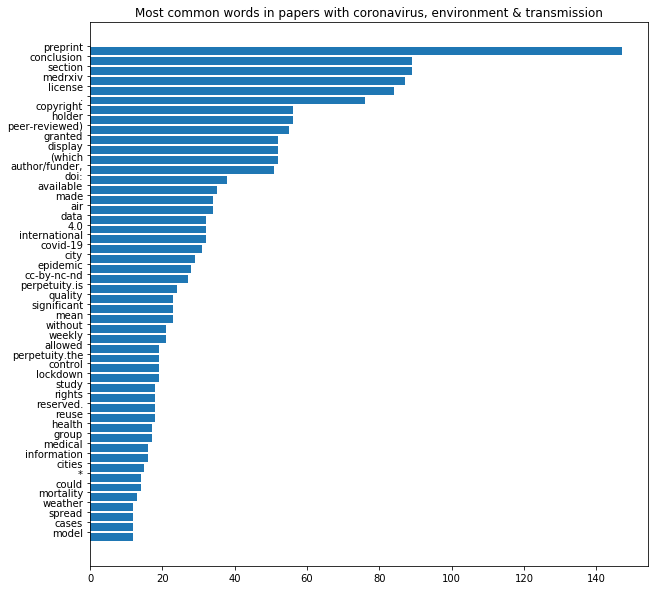

In [10]:
pd.set_option('display.width', 100000)

def word_bar_graph_function(df,column,title):
    # adapted from https://www.kaggle.com/benhamner/most-common-forum-topic-words
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w for w in popular_words if w not in stopwords.words("english")]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_nonstop[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_nonstop[0:50]))
    plt.title(title)
    plt.show()

plt.figure(figsize=(10,10))
word_bar_graph_function(environ_trans_conclusion, "conclusion", "Most common words in papers with coronavirus, environment & transmission")

We observe that some of these words are merely situational (i.e. conclusion, section, medrxiv), but others may be particularly common in the subset of papers we have filtered. For example, words like "epicenter", "humidity", "city", "distance" and "lockdown" seem particularly related to the transmission of the virus and the environmental effects, and they probably won't be that frequent in other articles. 

Let's compare this case with papers containing the word "susceptibility":

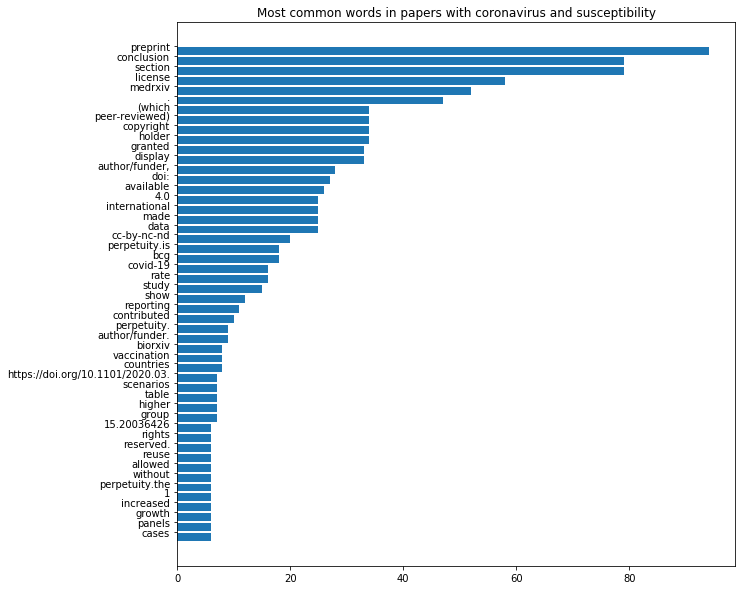

In [11]:
biorxiv_susceptibility = filter_papers_word_list(["coronavirus", "susceptibility"])
susceptibility_conclusion = extract_conclusion(biorxiv, biorxiv_susceptibility)
plt.figure(figsize=(10,10))
word_bar_graph_function(susceptibility_conclusion, "conclusion", "Most common words in papers with coronavirus and susceptibility")

As expected, in this case there is no trace of the words "epicenter", "humidity", "city", "distance" or "lockdown". Instead, we now see large frequencies for words like "reporting", "rate", "scenarios", "diagnostic" and "protocol", which are more related to the contagion suscpetibility of the population.

# 3. Most common words in conclusions by topic <a id="section3"></a>

In section 2 we've achieved our objective to extract the conclusion text of papers by their topic, based on a list of words. However, you will notice that there are words that do not provide any useful information, but are just situational in the Conclusion section (i.e. conclusion, section, preprint, license, copyright, etc). It's time to solve this and provide a cleaner list of the most common words in Conclusions filtered by topic. 

The main workflow is:
1. **Compare lists of words**. Provide a technique to verify if papers containing two different sets of lists are redundant
2. **Most common words in conclusion**. Except for stopwords, extract the most common words in the Conclusion section for all papers related to coronavirus
3. **Clean common words in conclusion by topic**. Compute the most common words by topic, but this time without irrelevant information

## 3.1. Compare lists of words

Since in many cases choosing the right set of words is not direct, I'll create a function tho verify if two different lists of words are equivalent or not. An example to compare papers with the word "environment" vs papers with "environmental":

In [12]:
def compare_papers_by_word(list1, list2):
    biorxiv_1 = filter_papers_word_list(list1)
    biorxiv_2 = filter_papers_word_list(list2)
    if len(biorxiv_2) == len(set(biorxiv_1)-(set(biorxiv_1)-set(biorxiv_2))):
        answer = "List 1 contains List2"
    else:
        answer = "Lists are different"
    return answer

list1 = ["environment"]
list2 = ["environmental"]
compare_papers_by_word(list1, list2)

'List 1 contains List2'

## 3.2. Most common words in conclusion

Now we need to know which are the most common words from all papers related to coronavirus, so we can substract them when plotting the most common words from papers of a given topic:

In [13]:
biorxiv_conclusion = filter_papers_word_list(["coronavirus"])
biorxiv_coronavirus_conclusion = extract_conclusion(biorxiv, biorxiv_conclusion)

# Filter out papers without Conclusions section
biorxiv_conclusion_informed = biorxiv_coronavirus_conclusion[biorxiv_coronavirus_conclusion["conclusion"] != "No Conclusion section"]
# Split in words
list_of_words = "".join([c for c in biorxiv_conclusion_informed.conclusion]).split()
# Remove stopwords
all_text_conclusion_nonstop = [w.lower() for w in list_of_words if w not in stopwords.words("english")]
# List of 100 most common words
most_common_words_conclusion = Counter(all_text_conclusion_nonstop).most_common(100)
most_common_words_conclusion

[('preprint', 830),
 ('license', 500),
 ('.', 482),
 ('medrxiv', 472),
 ('the', 417),
 ('copyright', 312),
 ('holder', 312),
 ('peer-reviewed)', 311),
 ('(which', 299),
 ('granted', 295),
 ('display', 295),
 ('author/funder,', 277),
 ('available', 253),
 ('it', 232),
 ('doi:', 223),
 ('made', 213),
 ('4.0', 207),
 ('international', 206),
 ('covid-19', 146),
 ('perpetuity.is', 145),
 ('cc-by-nc-nd', 132),
 ('data', 110),
 ('number', 103),
 ('we', 90),
 ('perpetuity.the', 87),
 ('in', 84),
 ('cases', 81),
 ('without', 76),
 ('figure', 73),
 ('model', 73),
 ('study', 72),
 ('epidemic', 72),
 ('patients', 68),
 ('no', 64),
 ('rights', 62),
 ('allowed', 62),
 ('all', 61),
 ('reserved.', 60),
 ('reuse', 60),
 ('using', 55),
 ('also', 54),
 ('1', 52),
 ('may', 51),
 ('population', 51),
 ('perpetuity.', 50),
 ('cc-by', 48),
 ('biorxiv', 48),
 ('health', 46),
 ('results', 46),
 ('group', 46),
 ('used', 44),
 ('this', 44),
 ('rate', 43),
 ('information', 42),
 ('medical', 41),
 ('author/funder.'

The list contains a lot of words that are just situational; preprint, license, medRxiv or copyright. This words add no value to our analysis, and hence should be removed when showing the most common words from the Conclusion of papers from a certain topic. My personal criteria through manual revision has lead to the following final list of 68 words:

In [14]:
manual_filter = [('preprint', 204),
 ('.', 137),
 ('license', 115),
 ('medrxiv', 108),
 ('the', 107),
 ('copyright', 78),
 ('holder', 78),
 ('peer-reviewed)', 78),
 ('available', 73),
 ('(which', 72),
 ('doi:', 64),
 ('granted', 63),
 ('display', 62),
 ('it', 62),
 ('author/funder,', 59),
 ('made', 53),
 ('4.0', 52),
 ('international', 52),
 ('data', 51),
 ('perpetuity.is', 35),
 ('cc-by-nc-nd', 28),
 ('study', 26),
 ('in', 21),
 ('we', 20),
 ('figure', 19),
 ('using', 18),
 ('author/funder.', 18),
 ('biorxiv', 18),
 ('number', 17),
 ('used', 17),
 ('sars-cov-2', 17),
 ('results', 16),
 ('covid-19', 16),
 ('perpetuity.the', 15),
 ('all', 15),
 ('1', 14),
 ('without', 13),
 ('show', 13),
 ('contributed', 13),
 ('our', 12),
 ('different', 12),
 ('2019-ncov', 12),
 ('also', 11),
 ('table', 11),
 ('coronavirus', 11),
 ('information', 11),
 ('cc-by-nc', 11),
 ('cc-by', 11),
 ('rights', 10),
 ('reserved.', 10),
 ('no', 10),
 ('reuse', 10),
 ('allowed', 10),
 ('based', 10),
 ('may', 10),
 ('consent', 10),
 ('authors', 10),
 ('https://doi.org/10.1101/2020.02.07.20021139', 10),
 ('2', 9),
 ('for', 9),
 ('however,', 9),
 ('this', 9),
 ('virus', 9),
 ('might', 8),
 ('manuscript', 8),
 ('https://doi.org/10.1101/2020.02.', 8),
 ('manuscript.', 8),
 ('reading', 8)]

## 3.3. Clean common words in conclusion by topic

Now the easy part, use the functions from previous sections to provide  alist of common words in the Conclusion section of a given subtopic: 

Papers containing coronavirus:  969


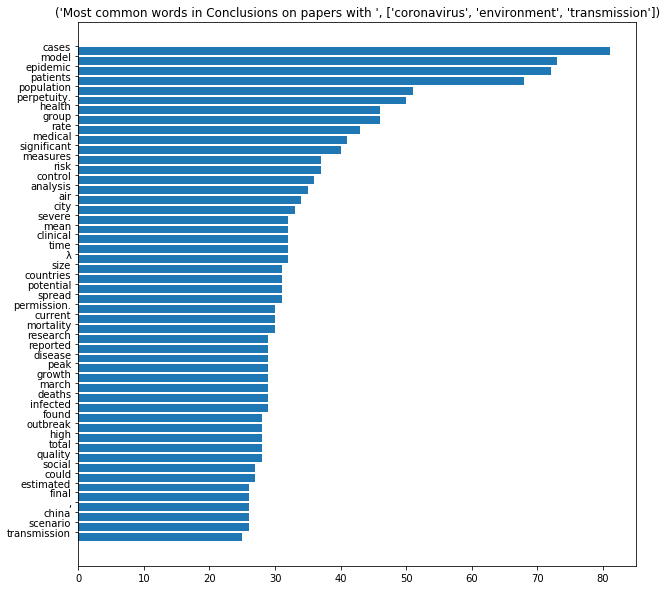

In [15]:
# Modify slightly Paul's function to prevent irrelevant words to appear
def word_bar_graph_function_mod(df,column,title,exception):
    # adapted from https://www.kaggle.com/benhamner/most-common-forum-topic-words
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    popular_words_nonstop = [w.lower() for w in popular_words if w not in stopwords.words("english")]
    popular_words_noexcep = [w.lower() for w in popular_words_nonstop if w not in exception]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words_noexcep[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words_noexcep[0:50]))
    plt.title(title)
    plt.show()
    
    
# Create a general function for cleaner
def common_words_conclusion_clean(word_list, exception_list):
    
    """
    word_list = list of words that should contain the paper
    exception_list = list of most common words in desired papers, in format [(word1, counter1), (word2, counter2),...]
    """

    # Papers with the word coronavirus (I've verified that it contains all papers with COVID-19 and other key words)
    biorxiv_coronavirus = filter_papers_word_list(["coronavirus"])
    print("Papers containing coronavirus: ", len(biorxiv_coronavirus))

    # Extract Conclusion from these papers, filter out papers without it
    biorxiv_coronavirus_conclusion = extract_conclusion(biorxiv, biorxiv_coronavirus)
    biorxiv_coronavirus_conclusion = biorxiv_coronavirus_conclusion[biorxiv_coronavirus_conclusion["conclusion"] != "No Conclusion section"]

    exception_words = [x[0] for x in exception_list]

    plt.figure(figsize=(10,10))
    title = "Most common words in Conclusions on papers with ", word_list
    word_bar_graph_function_mod(biorxiv_coronavirus_conclusion, "conclusion", title, exception_words)
    
    
common_words_conclusion_clean(["coronavirus", "environment", "transmission"], manual_filter)

This is a cleaner list of common words for COVID-19 papers related to environment and transmission. This could help people filter the papers they are interested in, so that there's no need to read the whole literature.

# 4. Text summarization <a id="section4"></a>

Previous sections have been focused into reducing the amount of information from papers so that anyone interested in the subject can focus on certain papers, and identify in a simple look which words are meant in the Conclusion section. However, sometimes working with the whole paper may be mandatory, hence requiring an alternative method to reduce the workload when reviewing papers. To tackle this problem we'll use text summarization.

Text summarization seeks to extract the most relevant information from a text, and it can be achieved through two different approaches:
* **Extractive**. Select a subset of words that retain the most important points, then select sentences with higher weights.
* **Abstractive**. Based on semantic understanding, the model aims to produce a completely new text, shorter than the original document but with the same message.

I'll proceed with extractive summarization given that in most cases we are interested in complete literal sentences from the papers, besides it's faster and the implementation is relatively simple. The main workflow that we will follow is:

1. **Word scoring**. Compute the term frequency - inverse frequency document ([TFIDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)) score for each word in the document
2. **Split**. Split the paper's text into sentences, using dot and line break as delimiters
3. **Sentence scoring**. Use text rank, with the sentence score based on word scores. Filter out sentences with >50 words
4. **Summary**. The summary consists on the top 10 sentences with higher score

With this approach, the maximum summary length is 500 words, which is a reasonable number given that abstracts usually range from 100 to 500 words. 

Let's see an example for the paper [Diagnosis of Acute Respiratory Syndrome Coronavirus 2 Infection by Detection of Nucleocapsid Protein running title: Diagnosis of COVID-19 by N antigen detection](https://www.medrxiv.org/content/10.1101/2020.03.07.20032524v2.full.pdf). The first step is to define the TFIDF function and then store in a dictionary the score of each word.

In [16]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words = 'english', sublinear_tf=True)
    matrix = tfidf_vectorizer.fit_transform(data)
    return matrix, tfidf_vectorizer

list_corpus = list(biorxiv[biorxiv.paper_id == '6d0127f985edbe088bc279865bef25a31f54a066'].text)

tfidf_matrix, tfidf_vectorizer = tfidf(list_corpus)
word_scores_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names())   # extract a df with the words' scores
word_scores = dict(zip(list(word_scores_df.columns), list(word_scores_df.iloc[0])))  # convert to dict

print("Arbitrary slice of 10 words from the dictionary")
dict(list(word_scores.items())[100:110])  

Arbitrary slice of 10 words from the dictionary


{'available': 0.06999895336557886,
 'avian': 0.0237614013407795,
 'based': 0.0237614013407795,
 'bat': 0.09720890163641414,
 'belonging': 0.0237614013407795,
 'beta': 0.04023154968629412,
 'bias': 0.049865968849734765,
 'binding': 0.0237614013407795,
 'bioedit': 0.0237614013407795,
 'biorxiv': 0.07317184637732334}

At this point we have a complete dictionary for all words in the paper, with their respective TFIDF scores. To split the paper into sentences, we **replace all line breaks** (\n, \r) **by dots** (.), and then split the document using the dot as a delimiter. Each **sentence's score is the sum of all its word's scores**, effectively penalizing short sentences (which I consider a desired criteria).

In [17]:
# Split into sentences
sentences_list = [nlp(s) for s in list(biorxiv[biorxiv.paper_id == '6d0127f985edbe088bc279865bef25a31f54a066'].text.str.replace('\n', '.').replace('\r', '.'))]
sentences_list = str(sentences_list[0]).split('.')   # Split sentences by .
sentences_scores = {}

# Define the sentence scoring function
def get_sentence_score(sentence: str, word_scores: dict):
    words = sentence.split()
    if len(words) < 50:
        score = sum([word_scores.get(w.lower(),0) for w in words])
    else:
        score=0
    return score

# Assign scores and join the top10 sentences into the final summary
for s in sentences_list:
    sentences_scores[s] = get_sentence_score(s, word_scores)
    
top10_sentences = nlargest(10, sentences_scores, key=sentences_scores.get)
top10_sentences = [s for s in top10_sentences ]
summary = ' '.join(top10_sentences)

print("Original paper size: ", len(list_corpus[0].split()))
print("Summary size: ", len(summary.split()))
print("Reduction percentage: ", 100-round(len(summary.split())/len(list_corpus[0].split())*100, 2), "%")

Original paper size:  2467
Summary size:  359
Reduction percentage:  85.45 %


This method has reduced the original document to a 18.86% of the original, which considering the increasingly large number of papers in the literature, would save many time to anyone interested into reading them partially. The obtained summary is the following:

In [18]:
print(summary)

To investigate the potential relative synonymous codon usage (RSCU) bias of the spike protein from SARS-CoV-2 and its closely related coronaviruses, the coding sequence (CDS) of spike protein in these coronaviruses were calculated with CodonW 1  Compared with RaTG13 genome, many nucleotide substitutions are observed, but there are only five small inserts and deletions (indels) mutations, and the largest insert segment in WIV04 genome was " CGGCGGGCACGT " sequence, which is located near the boundary of S1 and S2 regions of spike protein  The results showed that both dN and dS of S gene of SARS-CoV-2 WIV04 versus Bat-SARr-CoV RaTG13 were the lowest among all typical coronaviruses, while those of SARS-CoV Tor2 versus bat SARS-like coronavirus WIV1 were the second lowest  In this work, we investigated the mutation pattern of SARS-CoV-2 by comprehensive comparative genomic analysis of the nonsynonymous/ synonymous substitution, relative synonymous codon usage (RSCU) and selective pressure i

A version of the above code for direct copy-paste purposes:

In [19]:
# Term frequency - inverse document frequency function
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words = 'english', sublinear_tf=True)
    matrix = tfidf_vectorizer.fit_transform(data)
    return matrix, tfidf_vectorizer


# Define the sentence scoring function
def get_sentence_score(sentence: str, word_scores: dict):
    words = sentence.split()
    if len(words) < 50:
        score = sum([word_scores.get(w.lower(),0) for w in words])
    else:
        score=0
    return score


# Summary extraction function
def extract_summary(df, paper_id):

    list_corpus = list(biorxiv[biorxiv.paper_id == paper_id].text)
    tfidf_matrix, tfidf_vectorizer = tfidf(list_corpus)
    word_scores_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names())   # extract a df with the words' scores
    word_scores = dict(zip(list(word_scores_df.columns), list(word_scores_df.iloc[0])))  # convert to dict

    # Split into sentences
    sentences_list = [nlp(s) for s in list(biorxiv[biorxiv.paper_id == paper_id].text.str.replace('\n', '.').replace('\r', '.'))]
    sentences_list = str(sentences_list[0]).split('.')   # Split sentences by .
    sentences_scores = {}

    # Assign scores and join the top10 sentences into the final summary
    for s in sentences_list:
        sentences_scores[s] = get_sentence_score(s, word_scores)

    top10_sentences = nlargest(10, sentences_scores, key=sentences_scores.get)
    top10_sentences = [s for s in top10_sentences ]
    summary = ' '.join(top10_sentences)
        
    return summary

Notice that an input DataFrame is required, in order to generate the new summary column. In case you are interested into summarizing only some papers, you can first filter these papers from the dataframe. Results of the the previous case for reports with the words "coronavirus", "environment" and "transmision" are the following:

In [20]:
environ_trans_summary = environ_trans_conclusion.copy()
environ_trans_summary['summary'] = environ_trans_summary['paper_id'].apply(lambda x: extract_summary(environ_trans_summary, x))
environ_trans_summary.head(5)

paper_id                                              title                                            authors                                       affiliations                                           abstract                                               text                                       bibliography                                        raw_authors                                   raw_bibliography                                         conclusion                                            summary
10  7f73d8a7944270ae9ba4a1793885786d36588bc3  The Effect of Large-Scale Anti-Contagion Polic...  Solomon Hsiang, Daniel Allen, Sébastien Annan-...  Solomon Hsiang (UC Berkeley), Daniel Allen (UC...  Abstract\n\nGovernments around the world are r...  Introduction\n\nThe 2019 novel coronavirus 1 p...  Substantial undocumented infection facilitates...  [{'first': 'Solomon', 'middle': [], 'last': 'H...  {'BIBREF0': {'ref_id': 'b0', 'title': 'Substan...                              No Conclusion section  Daily growth rates of infections To estimate t...
17  1a12cc7d49d8521bec5d447ebb413cbcf5aca8f4  Study of the mental health status of medical p...  Jun Xing, Ning Sun, Jun Xu, # , Shuling Geng, ...  Jun Xing (The Second Affiliated Hospital of Ha...  Abstract\n\nObjective: This paper studied the ...  \n\nNovel coronavirus pneumonia (NCP) is a pat...  Report of clustering pneumonia of unknown etio...  [{'first': 'Jun', 'middle': [], 'last': 'Xing'...  {'BIBREF0': {'ref_id': 'b0', 'title': 'Report ...  \nIn the face of the catastrophic health emerg...   In subsequent research in this project, a lon...
38  e367637e063ec728b13f3685e8aee5f775c553cd  Roles of meteorological conditions in COVID-19...  Biqing Chen, Hao Liang, Xiaomin Yuan, Yingying...  Biqing Chen (the Affiliated Hospital of Nanjin...  Abstract\n\nThe novel coronavirus (SARS-CoV-2/...  INTRODUCTION\n\nIn the first season of 2020, a...  A novel coronavirus from patients with pneumon...  [{'first': 'Biqing', 'middle': [], 'last': 'Ch...  {'BIBREF0': {'ref_id': 'b0', 'title': 'A novel...                              No Conclusion section  20037168 doi: medRxiv preprint Using this full...
60  12c8ef5614d9a35bed3ff95a3b1dc971842514fe  A planarian nidovirus expands the limits of RN...  Amir Saberi, Anastasia A Gulyaeva, John L Brub...  Amir Saberi (University of Illinois at Urbana-...  Abstract\n\nRNA viruses are the only known RNA...  Introduction\n\nRadiation of primitive life ov...  The antiquity of RNA-based evolution, G F Joyc...  [{'first': 'Amir', 'middle': [], 'last': 'Sabe...  {'BIBREF0': {'ref_id': 'b0', 'title': 'The ant...                              No Conclusion section   Since the ORF1b-size barrier can be overcome ...
64  6d0127f985edbe088bc279865bef25a31f54a066  Comparative genomic analysis revealed specific...  Longxian Lv, Gaolei Li, Jinhui Chen, Xinle Lia...  Longxian Lv (Zhejiang University), Gaolei Li (...  Abstract\n\nThe novel coronavirus SARS-CoV-2 (...  Introduction\n\nSARS-CoV-2, also known as 2019...  Does SARS-CoV-2 has a longer incubation period...  [{'first': 'Longxian', 'middle': [], 'last': '...  {'BIBREF0': {'ref_id': 'b0', 'title': 'Does SA...                              No Conclusion section  To investigate the potential relative synonymo...

And that's it! Hopefully this will help to reduce the workload when reviewing tons of papers, or to filter information for data processing purposes. Of course, this summarization technique can be applied to other language projects, so feel free to adapt it to them.

# 5. Exploration of COVID-19 papers by topic <a id="section3"></a>

Techniques reviewed in the previous sections have proven their utility, but now it's time to apply them and analyze the content of the papers. The main idea is to characterize some topics of the articles, so that we are able to understand which factors are more important in each of them. 

Remind that our final objective is to answer some of the open question about the COVID-19 spread, and to help scientists when dealing with the huge set of articles related to this topic. Hence, to facilitate access to the different tasks of the challenge, each of them will be covered in a separated subsection:

1. What is known about transmission, incubation, and environmental stability?
2. What do we know about COVID-19 risk factors?
3. What do we know about virus genetics, origin, and evolution?
4. Sample task with sample submission
5. What do we know about non-pharmaceutical interventions?
6. What do we know about vaccines and therapeutics?
7. What has been published about ethical and social science considerations?
8. What do we know about diagnostics and surveillance?
9. What has been published about medical care?
10. What has been published about information sharing and inter-sectoral collaboration?

## 5.1. What is known about transmission, incubation, and environmental stability?

* **Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.**

In [21]:
biorxiv_incub_hum = filter_papers_word_list(["coronavirus", "incubation", "human"])
biorxiv_incub_hum_conclusion = extract_conclusion(biorxiv, biorxiv_incub_hum)

biorxiv_incub_hum_summary = biorxiv_incub_hum_conclusion.copy()
biorxiv_incub_hum_summary['summary'] = biorxiv_incub_hum_summary['paper_id'].apply(lambda x: extract_summary(biorxiv_incub_hum_summary, x))
biorxiv_incub_hum_summary.head(5)

paper_id                                              title                                            authors                                       affiliations                                           abstract                                               text                                       bibliography                                        raw_authors                                   raw_bibliography                                         conclusion                                            summary
11  c8c052d27aaf8015316dcd2644fa5e0b3870cea1  Modeling the Comparative Impact of Individual ...  Corey M Peak, Rebecca Kahn, Yonatan H Grad, La...  Corey M Peak (Harvard T.H. Chan School of Publ...  Abstract\n\nIndividual quarantine and active m...  Introduction\n\nIn December 2019, Coronavirus ...  Coronavirus 2019-nCoV Global Cases, , , None; ...  [{'first': 'Corey', 'middle': ['M'], 'last': '...  {'BIBREF0': {'ref_id': 'b0', 'title': 'Coronav...                              No Conclusion section   Daily count of cumulative infections (red), t...
21  0fbb18050e29ca78191625d42576b1c574027377  Rapid Molecular Detection of SARS-CoV-2 (COVID...  Yinhua Zhang, Nelson Odiwuor, Jin Xiong, Luo S...  Yinhua Zhang (New England Biolabs, 240 County ...  Abstract\n\nThe ability to detect an infectiou...  INTRODUCTION\n\nThe emergence of a new coronav...  RNA based mNGS approach identifies a novel hum...  [{'first': 'Yinhua', 'middle': [], 'last': 'Zh...  {'BIBREF0': {'ref_id': 'b0', 'title': 'RNA bas...                              No Conclusion section   DNA fragments containing these two regions we...
23  5bbc428de7fc2f10c24d8439edda26d84b319687  Estimation of the Time-Varying Reproduction Nu...  Chong You, Yuhao Deng, Wenjie Hu, Jiarui Sun, ...  Chong You (Peking University, China), Yuhao De...  Abstract\n\nmedRxiv preprint Background: The 2...  Introduction\n\nOn December 29, 2019, Wuhan, t...  Clinical features of patients infected with 20...  [{'first': 'Chong', 'middle': [], 'last': 'You...  {'BIBREF0': {'ref_id': 'b0', 'title': 'Clinica...  \nDespite the continuous increase in new confi...  Despite the continuous increase in new confirm...
28  f7670779a419e53a1ac3fa2ae2471473f50ec42e  Short-term forecasts and long-term mitigation ...  Qihui Yang, Chunlin Yi, Aram Vajdi, Lee W Cohn...  Qihui Yang (Kansas State University, Manhattan...  Abstract\n\nAs an emerging infectious disease,...  Introduction\n\nThe 2019 novel coronavirus dis...  Simulating non-Markovian stochastic processes,...  [{'first': 'Qihui', 'middle': [], 'last': 'Yan...  {'BIBREF0': {'ref_id': 'b0', 'title': 'Simulat...  \nIn this work, the ensemble Kalman filter is ...  To reconstruct the epidemics in Hubei province...
29  2afff5fe89a3e3ec270a41c2b929dfeec68d7d50  Real-Time Estimation of the Risk of Death from...  Sung-Mok Jung, Andrei R Akhmetzhanov, Katsuma ...  Sung-Mok Jung (Hokkaido University, Kita 15 Jo...  Abstract\n\nThe exported cases of 2019 novel c...  Introduction\n\nSince 8 December, 2019, cluste...  World Health Organization. Novel Coronavirus-C...  [{'first': 'Sung-Mok', 'middle': [], 'last': '...  {'BIBREF0': {'ref_id': 'b0', 'title': 'World H...                              No Conclusion section   As part of the sensitivity analysis, Table S2...